# Template for importing and processing the data

The data file contains the raw output from the scanner (Columbus is used as an example). It is imported and processed in a table containing the treatment annotations (Protocol 2, steps 1 and 2). Basic quality control is performed (Protocol 2, step 3). Finally the annotated data is normalized using the GR method and sensitvity metrics are calculated (Protocol 3, steps 1 and 2).

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import datarail.utils.plate_fcts as pltfct
import datarail.import_modules.columbus_import_functions as CoImp
import datarail.data_processing.drug_response.treatment_annotation as TrtAnnot
import gr50
import gr50.plot

import matplotlib.pyplot as plt
%matplotlib inline

## Data import and annotation (protocol 2, steps 1 and 2)

In [2]:
# load the synthetic data (Columbus output)
df = CoImp.Columbus_processing('../tests/drug_response_data/OUTPUT/Example1_Columbus_output.tsv',
                              (('Hoechst_pos', 'cell_count__total'),
                               ('LDR_pos_Hoechst_neg', 'corpse_count'),
                               ('Hoechst_LDR_pos', 'cell_count__dead')),
                              'cell_count__total - cell_count__dead')

# annotate the data
df_annotated = TrtAnnot.add_treatments(
    TrtAnnot.add_plate_info(df,
        pd.read_csv('../tests/drug_response_data/OUTPUT/Example1_plate_info.tsv', sep='\t')),
    '../tests/drug_response_data/OUTPUT/')


df_annotated.concentration = (10**np.round(np.log10(df_annotated.concentration),3))
df_annotated.to_csv('OUTPUT/AnnotatedData_Example1.tsv', sep='\t', index=False)

df_mean = df_annotated.groupby(
    ['agent', 'concentration','cell_line' ,'treatment_duration', 'role'],
    as_index=False).mean().drop(['Column', 'Row'],axis=1)
df_mean.to_csv('OUTPUT/MeanData_Example1.tsv', sep='\t', index=False)

Default number of fields: 6 ; 505 wells with missing field(s)


/Users/mah47/Dropbox (HMS-LSP)/GitHub/datarail/datarail/import_modules/columbus_import_functions.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfout.cell_count[dfout.cell_count<0] = 0


,agent,concentration,cell_line,treatment_duration,role,cell_count__total,corpse_count,cell_count__dead,cell_count
0,-,0.0,CL_1,0,untreated,511.045833,33.787500,19.520833,491.525000
1,-,0.0,CL_1,72,negative_control,3688.833333,33.583333,60.983333,3627.850000
2,-,0.0,CL_2,0,untreated,512.720833,33.879167,19.529167,493.191667
3,-,0.0,CL_2,72,negative_control,2649.466667,33.366667,47.433333,2602.033333
4,-,0.0,CL_3,0,untreated,512.720833,33.525000,19.420833,493.300000


## Quality control (protocol 2, step 3)

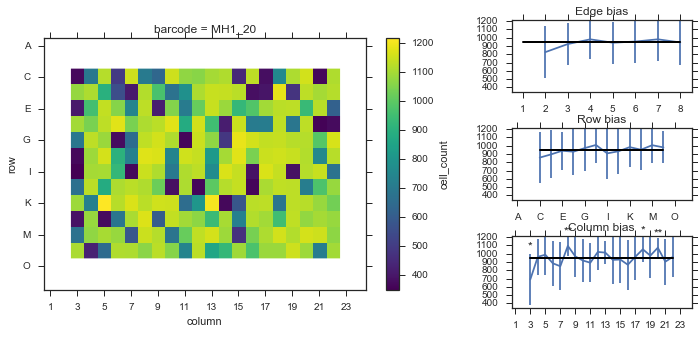

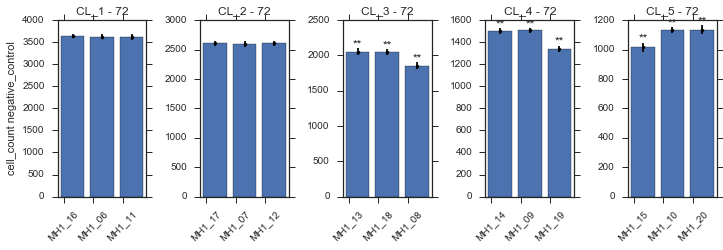

In [6]:
import datarail.data_processing.drug_response.qc_plate as qcfct

# use the raw data to perform the plate QC
qcfct.Plate_bias(pltfct.dfplate2xr(df), filename='OUTPUT/QC_report_Example1.pdf')
# use the annotated data to perform QC based on the negative controls
qcfct.Negative_control_bias(df_annotated)

## Calculate the GR values (protocol 3, step 1)

In [4]:
df_ctrl = gr50.assign_ctrls(df_mean,['cell_line'])
df_gr = gr50.compute_gr(df_ctrl.drop(
    ['role','cell_count__dead','corpse_count','cell_count__total'],axis=1))
df_gr.to_csv('OUTPUT/GRvalues_Example1.tsv', sep='\t', index=False)
df_gr.head()

,agent,cell_count,cell_count__ctrl,cell_count__time0,cell_line,concentration,treatment_duration,GRvalue
0,D_1,3583.444444,3627.85,491.525,CL_1,0.001000,72.0,0.991477
1,D_1,3523.555556,3627.85,491.525,CL_1,0.003162,72.0,0.979872
2,D_1,3251.111111,3627.85,491.525,CL_1,0.010000,72.0,0.925386
3,D_1,2709.333333,3627.85,491.525,CL_1,0.031623,72.0,0.807442
4,D_1,1758.666667,3627.85,491.525,CL_1,0.100000,72.0,0.555907


## Evaluate the GR metrics and plot the dose-response curves (protocol 3, step 2)

  cell_line  treatment_duration agent      GR50     GRmax    GR_AOC     GEC50  \
0      CL_1                72.0   D_1  0.126694 -0.173219  0.521802  0.180525   
1      CL_1                72.0   D_2  0.311339 -0.004149  0.375409  0.311598   
2      CL_1                72.0   D_3  0.691132  0.401488  0.403501  0.039195   
3      CL_1                72.0   D_4  3.702701 -0.096725  0.117403  4.167340   
4      CL_1                72.0   D_5  0.668048 -0.094074  0.312610  0.739586   

      GRinf      h_GR        r2          pval  
0 -0.195113  0.930441  0.999900  9.992007e-15  
1 -0.001168  2.804299  0.999948  9.992007e-16  
2  0.276385  0.280398  0.999647  8.226753e-13  
3 -0.193759  2.770500  0.999966  2.220446e-16  
4 -0.106589  1.899547  0.999925  3.663736e-15  


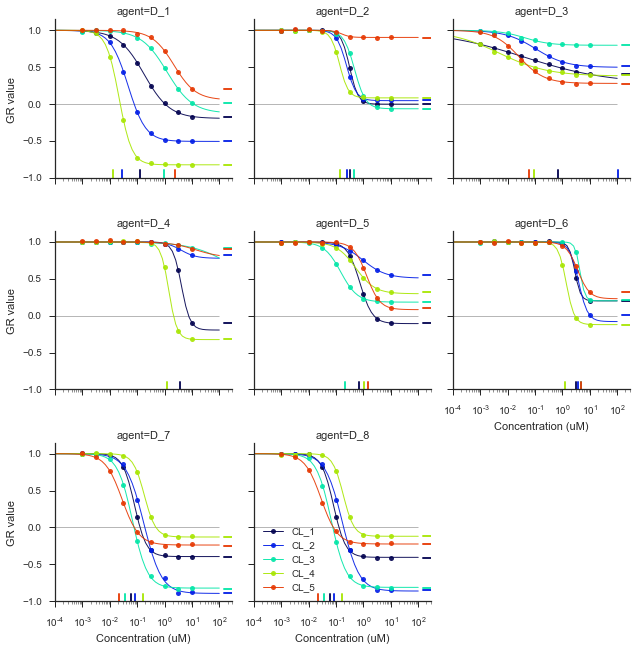

In [5]:
df_grmetrics = gr50.gr_metrics(df_gr)
df_grmetrics.to_csv('OUTPUT/GRmetrics_Example1.tsv', sep='\t', index=False)
print df_grmetrics.head()
fig = gr50.plot.plot_curves(df_grmetrics, df_gr, colorvar='cell_line', colvar='agent')
fig.savefig('OUTPUT/GRcurves_Example1.pdf')